# **Temat projektu : Wykrywanie figur szachowych Lichess za pomocą OpenCV i Template Macthing**
#### **Nazwa przedmiotu:** Analiza danych multymedialnych 

#### **Autorzy:** Konrad Konieczny 107379, Viktoriia Tsiupiak 107390

#### **Numer grupy zajęciowej:** M_I_NWh_INF_SIiUM_**1m**

#### **Prowadzący :** Łukasz Jeleń

#### **Link do repozytorium:** https://github.com/Psyhackological/opencv-chess-fen


# **WSTĘP**

Głównym celem niniejszego projektu jest zaprojektowanie i implementacja systemu wizyjnego umożliwiającego automatyczną identyfikację figur szachowych oraz odtworzenie stanu gry na podstawie statycznego obrazu cyfrowej planszy szachowej. Projekt koncentruje się na analizie zrzutów ekranu pochodzących z popularnej platformy szachowej Lichess (wykorzystując zestawy graficzne figur).

Realizacja tego celu zakłada wykorzystanie technik komputerowego przetwarzania obrazu (ang. Computer Vision) przy użyciu biblioteki OpenCV. Kluczowym elementem rozwiązania jest zastosowanie metody dopasowywania wzorców (Template Matching) do klasyfikacji zawartości poszczególnych pól szachownicy.

# **OPIS DANYCH** 

Realizacja projektu opiera się na ustrukturyzowanym zbiorze danych graficznych, podzielonym na zasoby referencyjne (wzorce) oraz dane wejściowe (próbki gier). Struktura katalogów oraz formaty plików zostały dobrane tak, aby umożliwić elastyczne testowanie algorytmu.

**1. Baza wzorców (Katalog: `assets/pieces`)**
Fundamentem działania algorytmu *Template Matching* jest bogata baza stylów graficznych wykorzystywanych na platformie Lichess.

* **Zawartość:** Zbiór obejmuje **39 unikalnych motywów szachowych** (m.in. *cburnett, horsey, merida, leipzig*). Każdy motyw znajduje się w dedykowanym podkatalogu.
* **Formaty plików:** W ramach każdego motywu, grafiki bierek dostępne są w dwóch formatach:
* **PNG:** Obrazy rastrowe z kanałem alfa (przezroczystością), które stanowią bezpośredni wzorzec dla algorytmu OpenCV.
* **SVG:** Grafika wektorowa, zapewniająca referencję o nieskończonej skalowalności.


* **Konwencja nazewnictwa:** Pliki posiadają ustandaryzowane sygnatury kodujące kolor i typ figury (np. `wP.png` – *white Pawn* / biały pion, `bK.svg` – *black King* / czarny król). Umożliwia to automatyczną iterację po zbiorze i przypisywanie etykiet klasyfikacyjnych.

**2. Próbki do analizy (Katalog: `sample`)**
Zbiór walidacyjny stanowią kompletne zrzuty ekranu z rozgrywek szachowych.
* Obrazy te przedstawiają rzeczywiste sytuacje na szachownicy (gry środkowe, końcówki, debiuty).
* Pełnią one funkcję obrazu głównego (*Source Image*), na którym algorytm dokonuje segmentacji siatki pól i poszukuje wystąpień wzorców zdefiniowanych w punkcie 1.

**3. Tła planszy i selekcja cech**
W strukturze danych projektu znajduje się również katalog zawierający grafiki teł szachownic. Należy jednak zaznaczyć, że w przyjętej metodyce badawczej pliki te **nie zostały wykorzystane w procesie detekcji**.

Decyzja ta wynika ze specyfiki zaimplementowanego algorytmu dopasowywania (Template Matching):

* Proces detekcji został zaprojektowany tak, aby bazować wyłącznie na **kształcie i konturze figury**.
* Dzięki wykorzystaniu plików PNG z przezroczystością (kanał alfa), algorytm nakłada "maskę" figury, ignorując informacje o kolorze lub teksturze pola pod figurą.
* Podejście to czyni algorytm bardziej uniwersalnym, uniezależniając skuteczność detekcji od zmieniających się teł planszy (drewno, marmur, jednolity kolor), skupiając się stricte na geometrii bierek zawartych w folderze `assets`.

# **OPIS I IMPLEMENTACJA METOD**

W tej części znajduje się kompletny kod realizujący nasz projekt. Żeby całość była czytelna i łatwa do zrozumienia, podzieliliśmy kod na kilka logicznych sekcji, które odpowiadają kolejnym etapom działania programu.

Każdy fragment kodu opatrzyliśmy komentarzem lub krótkim opisem. Wyjaśniamy w nich na bieżąco, co dokładnie dzieje się w danym kroku – od wczytania bibliotek i danych, przez pocięcie planszy na pola, aż po samo wykrywanie figur i wyświetlenie wyniku.

In [1]:
%pip install opencv-python matplotlib numpy

/home/konradkon/.cache/uv/builds-v0/.tmpu77ksQ/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


## **KROK 1. IMPORTY I KONFIGURACJA**

Ten fragment kodu odpowiada za wstępną konfigurację środowiska projektowego oraz zaimportowanie niezbędnych modułów do przetwarzania obrazu i obliczeń numerycznych. Zdefiniowano w nim kluczowe stałe globalne sterujące parametrami algorytmu, takie jak próg dopasowania wzorca. Oprócz tego zaimplementowano pomocniczą funkcję wizualizacyjną, która obsługuje konwersję przestrzeni barw z BGR na RGB, umożliwiając poprawną prewizualizację wyników przetwarzania bezpośrednio w notatniku Jupyter.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

THEME_NAME = 'cburnett'      
GAME_FILENAME = 'cburnett.png' 
MATCH_THRESHOLD = 0.80      

BASE_DIR = 'assets'
PIECES_PATH = os.path.join(BASE_DIR, 'pieces', THEME_NAME, 'pngs')
GAME_PATH = os.path.join(BASE_DIR, 'sample', GAME_FILENAME)

def show_img_jupyter(img, title="Obraz"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

## **KROK 2. KONWERSJA BGR -> RGB**
Biblioteka OpenCV domyślnie wczytuje obrazy w formacie BGR (Blue-Green-Red), podczas gdy standardowe biblioteki do wizualizacji (jak Matplotlib) oczekują formatu RGB (Red-Green-Blue). Bez zastosowania transformacji cv2.cvtColor, wyświetlany obraz miałby przekłamane kolory (np. czerwone elementy byłyby niebieskie), co utrudniłoby wizualną weryfikację poprawności działania algorytmu.

Wczytano obraz: cburnett.png
Wymiary: (720, 720, 3)


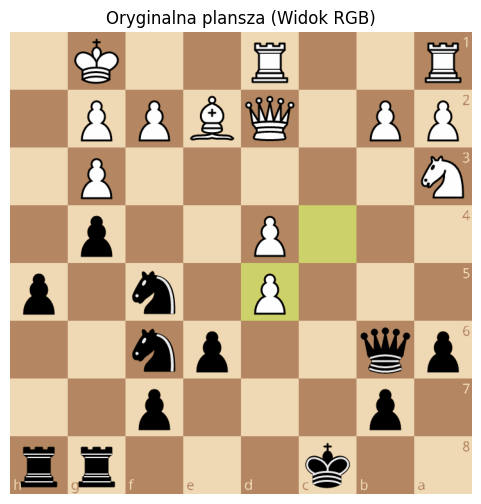

In [3]:
game_img = cv2.imread(GAME_PATH)

if game_img is None:
    print(f"BŁĄD: Nie znaleziono pliku: {GAME_PATH}")
else:
    game_img_rgb = cv2.cvtColor(game_img, cv2.COLOR_BGR2RGB)
    
    print(f"Wczytano obraz: {GAME_FILENAME}")
    print(f"Wymiary: {game_img.shape}")

    plt.figure(figsize=(6, 6))
    plt.imshow(game_img_rgb) 
    plt.title("Oryginalna plansza (Widok RGB)")
    plt.axis('off')
    plt.show()

## **KROK 3: SEGMENTACJA OBRAZU PLANSZY I EKSTRAKCJA PÓL**

Dekompozycja jednolitego obrazu całej planszy (macierzy 720x720 pikseli) na zbiór 64 niezależnych podobrazów o wymiarach 90x90 pikseli. Wykorzystując iteracyjne pętle, wyznaczamy współrzędne graniczne dla każdego pola szachowego i wycinamy odpowiadające im fragmenty.

Rozmiar pojedynczego pola: 90x90 px


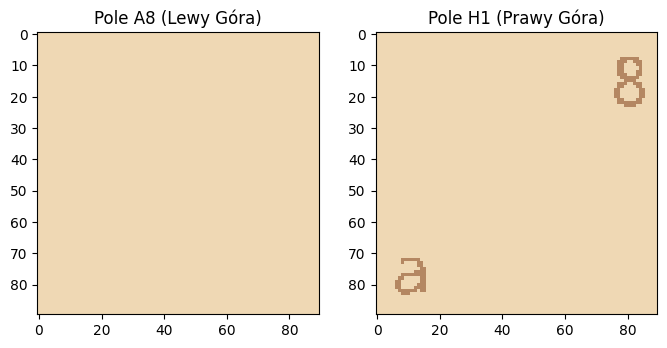

Plansza pocięta na 64 pola.


In [4]:
squares = [] 
rows_grid = [] 

height, width, _ = game_img.shape
square_size = height // 8

print(f"Rozmiar pojedynczego pola: {square_size}x{square_size} px")

for r in range(8):
    row_sq = []
    for c in range(8):
        y = r * square_size
        x = c * square_size
        
        crop = game_img[y:y+square_size, x:x+square_size]
        row_sq.append(crop)
    
    squares.append(row_sq)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(cv2.cvtColor(squares[0][0], cv2.COLOR_BGR2RGB))
axs[0].set_title("Pole A8 (Lewy Góra)")
axs[1].imshow(cv2.cvtColor(squares[7][7], cv2.COLOR_BGR2RGB))
axs[1].set_title("Pole H1 (Prawy Góra)")
plt.show()

print("Plansza pocięta na 64 pola.")

## **KROK 4: DETEKCJA, KLASYFIKACJA OBIEKTÓW I WIZUALIZACJA WYNIKÓW**
Przed uruchomieniem głównej pętli skrypt przygotowuje bazę wzorców, generując dla każdej bierki maskę binarną w celu eliminacji wpływu tła, oraz dokonuje geometrycznej segmentacji obrazu planszy na 64 niezależne fragmenty (ROI).Następnie algorytm przetwarza macierz 8x8 pól, stosując hybrydowe podejście do klasyfikacji: wstępną analizę statystyczną (wariancja) do odróżnienia pól pustych od zajętych, a potem dopasowanie wzorców (Template Matching) przy użyciu normy różnicowej TM_SQDIFF_NORMED (Im mniejszy wynik bliżej 0, tym lepsze dopasowanie.

Dodatkowo zaimplementowano heurystyczną logikę ratunkową (fallback logic) dla obiektów o niskim kontraście (głównie czarnych pionków). Cały proces kończy się wizualizacją wyników poprzez nałożenie ramek klasyfikacyjnych i etykiet na obraz wynikowy, co umożliwia natychmiastową weryfikację poprawności detekcji.

#### **Oznaczenie szachowych figur:**

Pierwsza literka
- **w** - oznacza White
- **b** - oznacza Black

Druga literka 
**P p - pawn**, **N n - knight**, **B b - bishop**, **R r - rook**, **Q q - queen**, **K k - king**

Na przykład : bk - czarny król

Wczytano obraz: cburnett.png
Myślę...
Analiza zakończona pomyślnie.


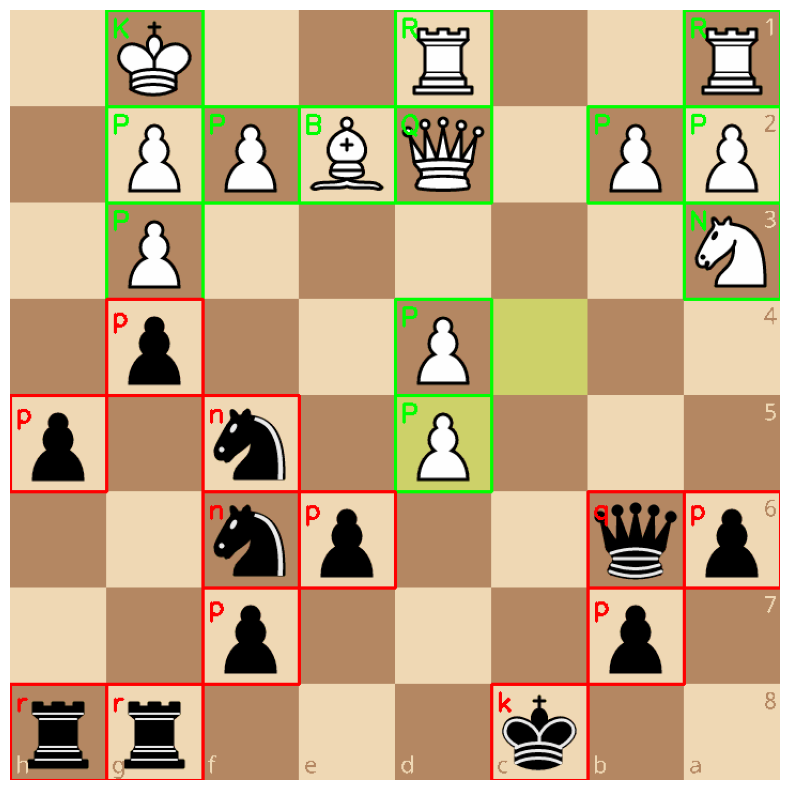

In [5]:
NAZWA_PLIKU = 'cburnett.png' 
SCIEZKA_FOLDERU = 'assets/sample'
PIECES_DIR = 'assets/pieces/cburnett/pngs' 

piece_filenames = {
    'P': 'wP.png', 'N': 'wN.png', 'B': 'wB.png', 'R': 'wR.png', 'Q': 'wQ.png', 'K': 'wK.png',
    'p': 'bP.png', 'n': 'bN.png', 'b': 'bB.png', 'r': 'bR.png', 'q': 'bQ.png', 'k': 'bK.png'
}

# WCZYTANIE WZORCÓW
templates = {}
for symbol, filename in piece_filenames.items():
    path = os.path.join(PIECES_DIR, filename)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: continue
    
# MASKA
    _, hard_mask = cv2.threshold(img[:, :, 3], 127, 255, cv2.THRESH_BINARY)
    templates[symbol] = {'img': img[:, :, :3], 'mask': hard_mask}

# WCZYTANIE OBRAZU 
full_path = os.path.join(SCIEZKA_FOLDERU, NAZWA_PLIKU)
game_img = cv2.imread(full_path)

if game_img is None:
    print(f"BŁĄD!: Nie znaleziono pliku: {full_path}")
else:
    print(f"Wczytano obraz: {NAZWA_PLIKU}")

# CIĘCIE
    squares = []
    for row in range(8):
        row_squares = []
        for col in range(8):
            y, x = row * 90, col * 90
            square = game_img[y:y+90, x:x+90]
            row_squares.append(square)
        squares.append(row_squares)

# FUNKCJE POMOCNICZE
    def is_square_empty(square_img, variance_threshold=20):
        """Sprawdza czy pole jest puste na podstawie odchylenia standardowego kolorów"""
        gray = cv2.cvtColor(square_img, cv2.COLOR_BGR2GRAY)
        std_dev = np.std(gray)
        return std_dev < variance_threshold

    def identify_piece(square_img, threshold=0.60):
        """Rozpoznaje figurę metodą Template Matching (SQDIFF)."""
        best_confidence = -1.0
        best_symbol = None
        
        for symbol, data in templates.items():
            res = cv2.matchTemplate(square_img, data['img'], cv2.TM_SQDIFF_NORMED, mask=data['mask'])
            min_diff, _, _, _ = cv2.minMaxLoc(res)
            confidence = 1.0 - min_diff
            
            if confidence > best_confidence:
                best_confidence = confidence
                best_symbol = symbol
                
        if best_confidence < threshold:
            return None, best_confidence
        
        return best_symbol, best_confidence

# ANALIZA PLANSZY 
    output_img = game_img.copy()
    board_str = [] 

    print("Myślę...")

    for row in range(8):
        row_str = []
        for col in range(8):
            square = squares[row][col]
            y, x = row * 90, col * 90
            
            if is_square_empty(square, variance_threshold=20):
                row_str.append('.')
                continue 
            
            piece, score = identify_piece(square, threshold=0.60)

# FALLBACK
            if piece is None:
                pawn_data = templates['p']
                res = cv2.matchTemplate(square, pawn_data['img'], cv2.TM_SQDIFF_NORMED, mask=pawn_data['mask'])
                min_diff, _, _, _ = cv2.minMaxLoc(res)
                pawn_confidence = 1.0 - min_diff
                
                if pawn_confidence > 0.45:
                    piece = 'p'
                else:
                    piece = 'p' 

            if piece:
                row_str.append(piece)
                color = (0, 255, 0) if piece.isupper() else (0, 0, 255)
                
                cv2.rectangle(output_img, (x, y), (x+90, y+90), color, 2)
                cv2.putText(output_img, piece, (x+5, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        board_str.append(row_str)

    print("Analiza zakończona pomyślnie.")


    img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

## **KROK 5: GENEROWANIE KODU FEN.**

W tym fragmencie kodu zaimplementowano prosty algorytm kompresji typu RLE (Run-Length Encoding) dla pustych pól. Iteruję po każdym wierszu macierzy i zamiast zapisywać każde puste pole osobno, zlicza ich ciągłe wystąpienia. Dopiero napotkanie figury lub koniec wiersza powoduje 'zrzucenie' licznika do ciągu wynikowego.

Na końcu łączenie wiersze separatorem '/' i dodaję domyślne nagłówki stanu gry (takie jak prawo do roszady czyj ruch), ponieważ z samego statycznego zdjęcia nie da się odczytać historii partii

In [6]:
try:
    board_data = board_str  
except NameError:
    print("BŁĄD!")
    board_data = None

if board_data:
    fen_rows = []

    for r in range(8):
        empty_count = 0
        current_row_str = ""
        
        for c in range(8):
            piece = board_data[r][c]  
            
            if piece == '.':  
                empty_count += 1
            else:
                if empty_count > 0:
                    current_row_str += str(empty_count)
                    empty_count = 0
                
                current_row_str += piece
        
        if empty_count > 0:
            current_row_str += str(empty_count)
            
        fen_rows.append(current_row_str)

    board_fen = "/".join(fen_rows)
    final_fen = f"{board_fen} w KQkq - 0 1"

    print("=" * 60)
    print(f"📋 TWÓJ WYNIK FEN:")
    print(f"{final_fen}")
    print("=" * 60)
    print(f"\n🔗 Lichess: https://lichess.org/analysis/{final_fen.replace(' ', '_')}")

📋 TWÓJ WYNIK FEN:
1K2R2R/1PPBQ1PP/1P5N/1p2P3/p1n1P3/2np2qp/2p3p1/rr3k2 w KQkq - 0 1

🔗 Lichess: https://lichess.org/analysis/1K2R2R/1PPBQ1PP/1P5N/1p2P3/p1n1P3/2np2qp/2p3p1/rr3k2_w_KQkq_-_0_1


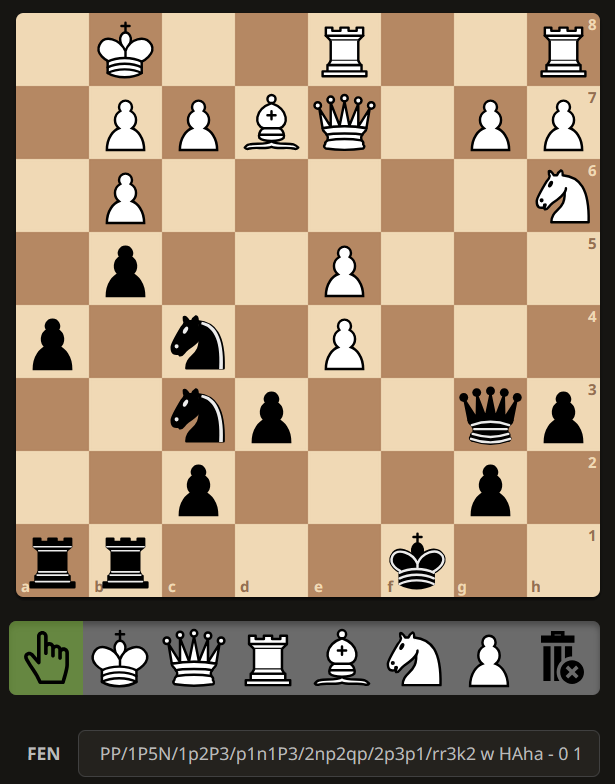

## **DETEKCJA ZDJĘĆ Z MOTYWEM CBURNETT**
### Poniżej znajduje się skrypt który zawiera wszystkie poprzednie kroki.

### **W jaki sposób skrypt został ulepszony?**

**1. Implementacja dynamicznej segmentacji**

Zastąpiono sztywne definiowanie rozmiaru pola (tzw. hardcoding), stosowane w prototypie, mechanizmem adaptacyjnym. W wersji finalnej wymiary siatki są obliczane dynamicznie na podstawie wysokości obrazu wejściowego. Zapewniło to niezależność systemu od rozdzielczości (resolution independence), umożliwiając poprawną analizę zarówno zrzutów ekranu, jak i zdjęć o wysokiej rozdzielczości.

**2. Zastosowanie detekcji niewrażliwej na skalę**

W celu rozwiązania problemu niedopasowania wielkości figur do wzorców, zaimplementowano algorytm dopasowania wieloskalowego. Proces detekcji obejmuje teraz analizę nie tylko w oryginalnej skali, ale również dla wersji przeskalowanych (pomniejszonych i powiększonych). Podejście to znacząco zwiększyło skuteczność detekcji (Recall), uniezależniając system od drobnych różnic w wielkości obiektów na planszy.

**3. Zmiana metryki porównawczej i optymalizacja wydajności**

Dokonano zmiany metody matematycznej z obliczania różnic (SQDIFF) na normowaną korelację wzajemną (CCOEFF_NORMED). Pozwoliło to na uzyskanie bardziej wiarygodnych wyników pewności (confidence score) oraz zwiększenie odporności na zmienne oświetlenie. Dodatkowo wprowadzono wstępną filtrację statystyczną opartą na badaniu odchylenia standardowego (np.std). Pozwala to na natychmiastową klasyfikację pól pustych i pominięcie kosztownych obliczeń, co zoptymalizowało czas działania algorytmu.

**4. Eliminacja ryzykownych heurystyk**

"Wyeliminowano stosowaną w prototypie heurystykę polegającą na domyślnym przypisywaniu czarnego piona w przypadku niepewnej detekcji. Dzięki zwiększeniu precyzji algorytmu, możliwe było oparcie decyzji klasyfikatora wyłącznie na wysokim progu pewności (0.60). Zredukowało to liczbę błędów typu False Positive i zwiększyło wiarygodność generowanego kodu FEN."


ANALIZA PLIKU: cburnett1.png
Myślę...


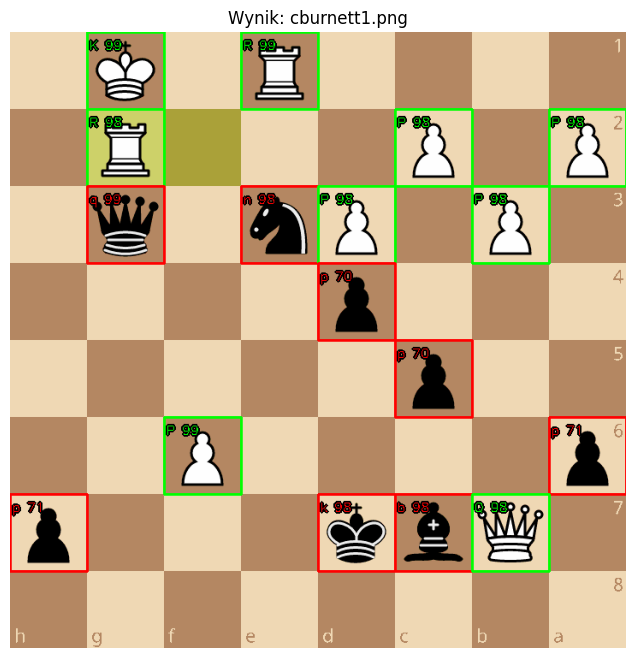

📋 FEN: 1K1R4/1R3P1P/1q1nP1P1/4p3/5p2/2P4p/p3kbQ1/8
🔗 Lichess: https://lichess.org/editor/1K1R4/1R3P1P/1q1nP1P1/4p3/5p2/2P4p/p3kbQ1/8

ANALIZA PLIKU: cburnett2.png
Myślę...


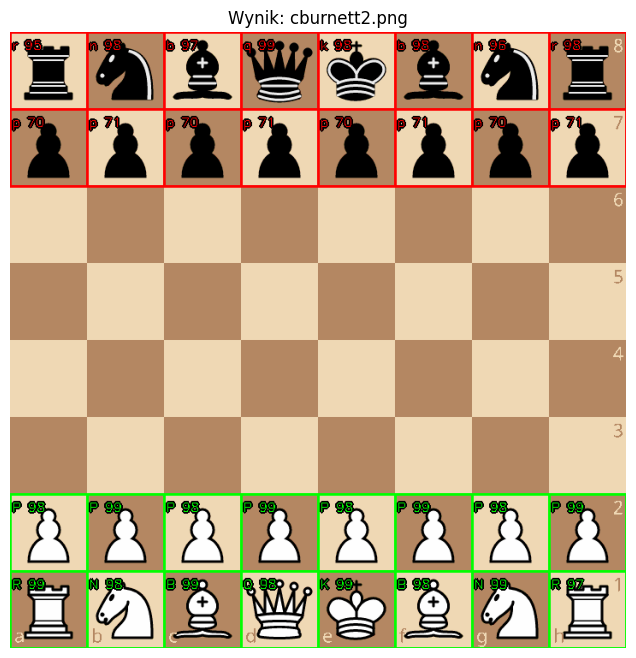

📋 FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR
🔗 Lichess: https://lichess.org/editor/rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR

ANALIZA PLIKU: cburnett3.png
Myślę...


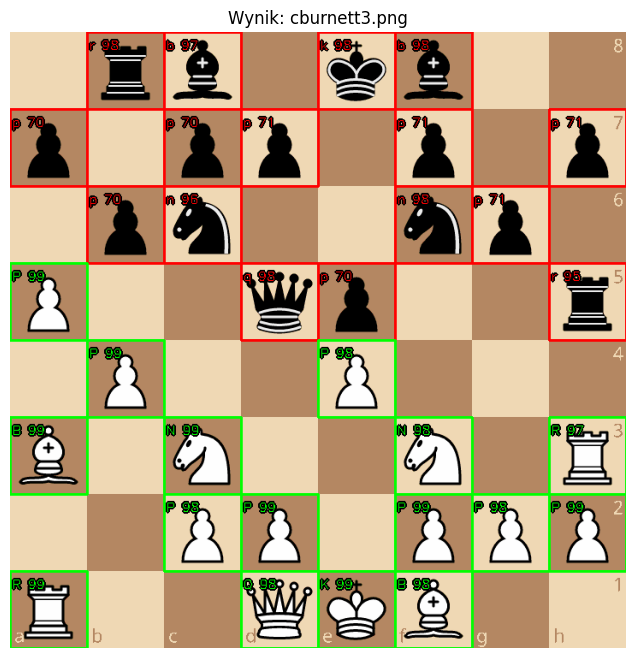

📋 FEN: 1rb1kb2/p1pp1p1p/1pn2np1/P2qp2r/1P2P3/B1N2N1R/2PP1PPP/R2QKB2
🔗 Lichess: https://lichess.org/editor/1rb1kb2/p1pp1p1p/1pn2np1/P2qp2r/1P2P3/B1N2N1R/2PP1PPP/R2QKB2

ANALIZA PLIKU: cburnett4.png
Myślę...


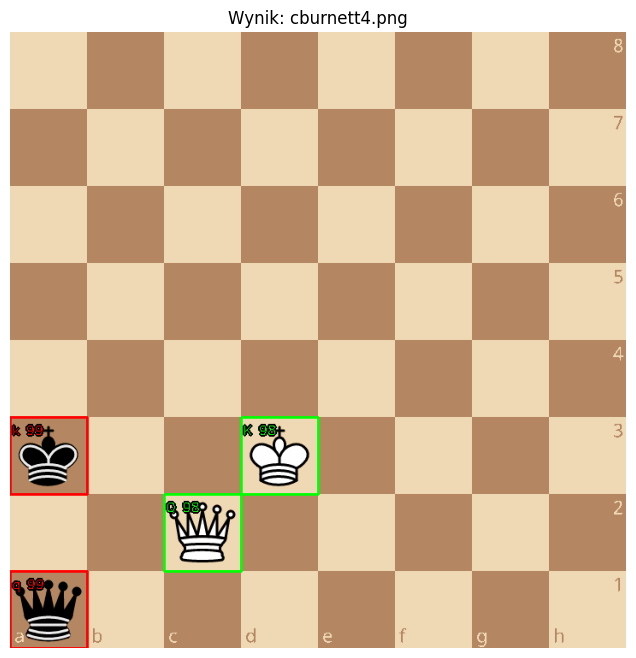

📋 FEN: 8/8/8/8/8/k2K4/2Q5/q7
🔗 Lichess: https://lichess.org/editor/8/8/8/8/8/k2K4/2Q5/q7

ANALIZA PLIKU: cburnett5.png
Myślę...


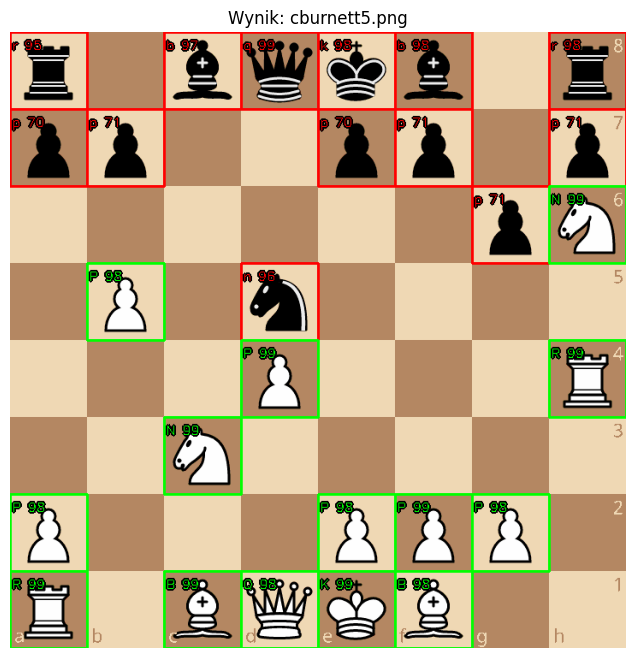

📋 FEN: r1bqkb1r/pp2pp1p/6pN/1P1n4/3P3R/2N5/P3PPP1/R1BQKB2
🔗 Lichess: https://lichess.org/editor/r1bqkb1r/pp2pp1p/6pN/1P1n4/3P3R/2N5/P3PPP1/R1BQKB2


In [7]:
BASE_DIR = 'assets'
THEME_NAME = 'cburnett'
PIECES_PATH = os.path.join(BASE_DIR, 'pieces', THEME_NAME, 'pngs')
GAME_FILENAMES = ['cburnett1.png', 'cburnett2.png', 'cburnett3.png', 'cburnett4.png', 'cburnett5.png']

MATCH_THRESHOLD = 0.60 

# FUNKCJE POMOCNICZE
def load_base_templates(path):
    temps = {}
    piece_map = {'P':'wP','N':'wN','B':'wB','R':'wR','Q':'wQ','K':'wK',
                 'p':'bP','n':'bN','b':'bB','r':'bR','q':'bQ','k':'bK'}
    for symbol, fname in piece_map.items():
        fpath = os.path.join(path, fname + ".png")
        img = cv2.imread(fpath, cv2.IMREAD_UNCHANGED)
        if img is not None:
            temps[symbol] = img
    return temps

def get_best_match_multiscale(square_img, templates_dict, base_size):
    best_score_global = -1.0
    best_piece_global = None
    
    if np.std(square_img) < 2.0:
        return None, 0.0

    scales = [0.85, 1.0, 1.15] 
    square_h, square_w = square_img.shape[:2]

    for symbol, raw_img in templates_dict.items():
        for scale in scales:
            target_size = int(base_size * scale)
            bgr = raw_img[:, :, :3]
            alpha = raw_img[:, :, 3]
            _, mask = cv2.threshold(alpha, 127, 255, cv2.THRESH_BINARY)
            
            t_img = cv2.resize(bgr, (target_size, target_size))
            t_mask = cv2.resize(mask, (target_size, target_size))
            
            if t_img.shape[0] > square_h or t_img.shape[1] > square_w:
                continue
                
            res = cv2.matchTemplate(square_img, t_img, cv2.TM_CCOEFF_NORMED, mask=t_mask)
            _, max_val, _, _ = cv2.minMaxLoc(res)
            
            if not np.isfinite(max_val):
                max_val = 0.0
            
            if max_val > best_score_global:
                best_score_global = max_val
                best_piece_global = symbol
                
    return best_piece_global, best_score_global

# GŁÓWNA PĘTLA
def analyze_smart(filename):
    print(f"\n{'='*40}")
    print(f"ANALIZA PLIKU: {filename}")
    
    path = os.path.join(BASE_DIR, 'sample', filename)
    img = cv2.imread(path)
    if img is None: 
        print("Brak pliku!")
        return

    output_img = img.copy()
    height, width, _ = img.shape
    square_size = height // 8
    
    base_templates = load_base_templates(PIECES_PATH)
    
    print(f"Myślę...")
    
# FEN
    fen_rows = [] 
    
    for r in range(8):
        empty_count = 0
        current_row_fen = ""
        
        for c in range(8):
            y, x = r * square_size, c * square_size
            square = img[y:y+square_size, x:x+square_size]
            
            piece, score = get_best_match_multiscale(square, base_templates, square_size)
            
            is_piece_found = False
            if score > MATCH_THRESHOLD and piece is not None:
                is_piece_found = True
            
            if is_piece_found:

                color = (0, 255, 0) if piece.isupper() else (0, 0, 255) 
                if score < 0.50: color = (0, 255, 255) # Ostrzeżenie
                
                cv2.rectangle(output_img, (x, y), (x+square_size, y+square_size), color, 2)
                
                label_txt = f"{piece} {int(score*100)}"
                cv2.putText(output_img, label_txt, (x+2, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 3)
                cv2.putText(output_img, label_txt, (x+2, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

                if empty_count > 0:
                    current_row_fen += str(empty_count)
                    empty_count = 0
                current_row_fen += piece
            else:
                empty_count += 1
        
        if empty_count > 0:
            current_row_fen += str(empty_count)
        
        fen_rows.append(current_row_fen)

    final_fen = "/".join(fen_rows)

    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Wynik: {filename}")
    plt.axis('off')
    plt.show()
    
    print(f"📋 FEN: {final_fen}")
    print(f"🔗 Lichess: https://lichess.org/editor/{final_fen}")

for f in GAME_FILENAMES:
    analyze_smart(f)

## **DETEKCJA ZDJĘĆ Z MOTYWEM MERIDA**

### **Do jakich zmian doszło w tej części kodu?**

**1. Preprocessing (CLAHE):** W tej wersji nie analizuję surowego obrazu, lecz najpierw konwertuję go do skali szarości i stosuję adaptacyjne wyrównanie histogramu (CLAHE). To uodporniło algorytm na nierównomierne oświetlenie i cienie na planszy.

**2. Logika rozmyta (Heurystyki):** Zauważono, że proste figury (piony) często generują fałszywe dopasowania. Wprowadzono więc system wag: 'karzę' wynik dopasowania dla pionów, a 'nagradzam' figury o unikalnej geometrii, jak skoczek. To znacząco zredukowało liczbę błędów klasyfikacji.

**3. Jakość próbowania:** Zmieniono metodę interpolacji przy skalowaniu na INTER_AREA, co eliminuje szumy przy zmniejszaniu wzorców, oraz zagęściłam zakres skalowania, co zwiększyło precyzję detekcji.


ANALIZA PLIKU: merida.png
Myślę...


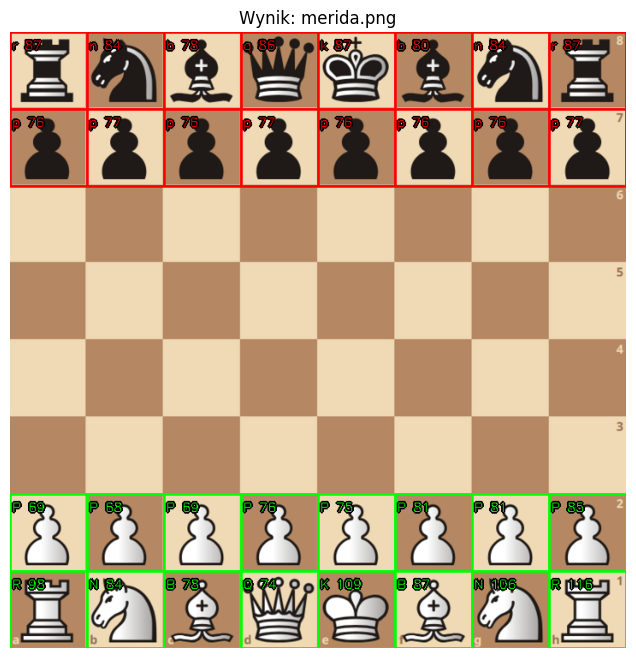

📋 FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR
🔗 Lichess: https://lichess.org/editor/rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR

ANALIZA PLIKU: merida1.png
Myślę...


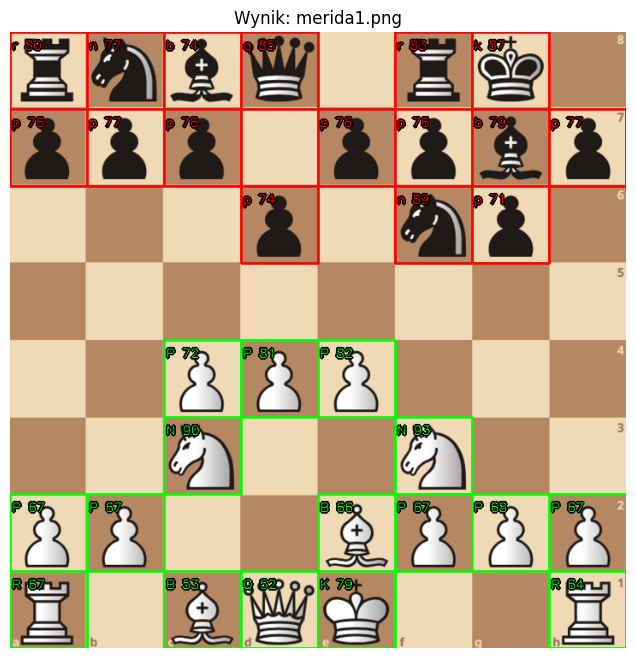

📋 FEN: rnbq1rk1/ppp1ppbp/3p1np1/8/2PPP3/2N2N2/PP2BPPP/R1BQK2R
🔗 Lichess: https://lichess.org/editor/rnbq1rk1/ppp1ppbp/3p1np1/8/2PPP3/2N2N2/PP2BPPP/R1BQK2R

ANALIZA PLIKU: merida2.png
Myślę...


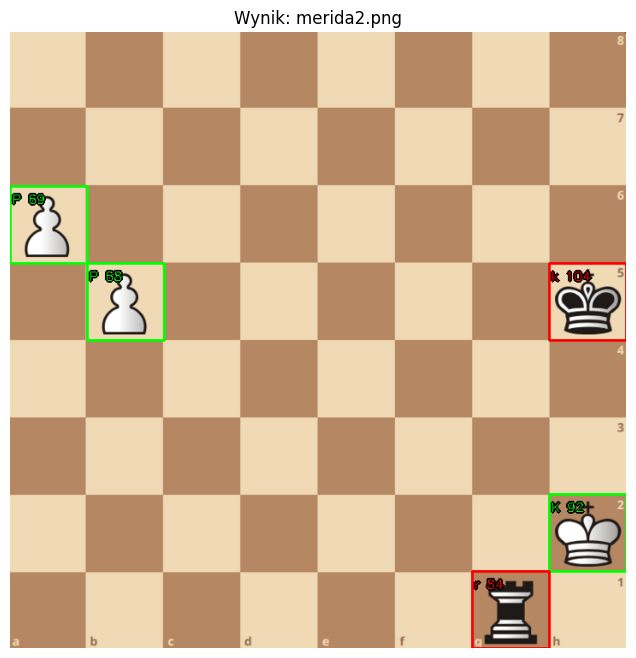

📋 FEN: 8/8/P7/1P5k/8/8/7K/6r1
🔗 Lichess: https://lichess.org/editor/8/8/P7/1P5k/8/8/7K/6r1

ANALIZA PLIKU: merida5.png
Myślę...


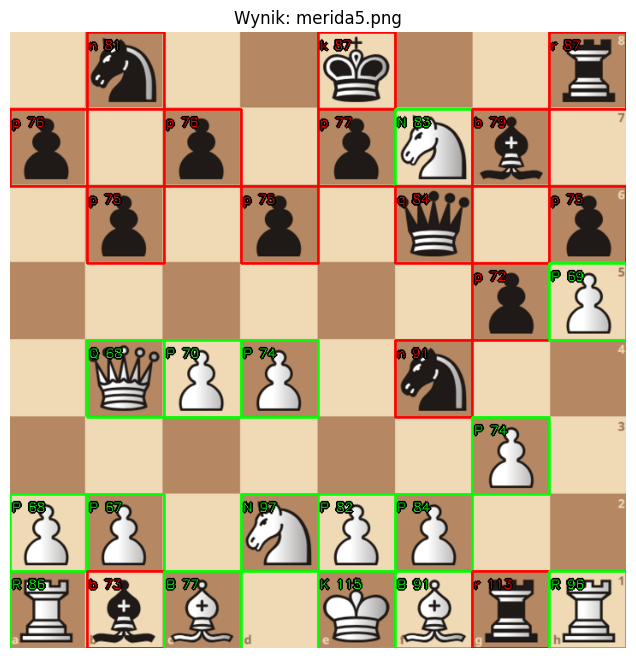

📋 FEN: 1n2k2r/p1p1pNb1/1p1p1q1p/6pP/1QPP1n2/6P1/PP1NPP2/RbB1KBrR
🔗 Lichess: https://lichess.org/editor/1n2k2r/p1p1pNb1/1p1p1q1p/6pP/1QPP1n2/6P1/PP1NPP2/RbB1KBrR

ANALIZA PLIKU: merida4.png
Myślę...


In [ ]:
BASE_DIR = 'assets'
THEME_NAME = 'merida'
PIECES_PATH = os.path.join(BASE_DIR, 'pieces', THEME_NAME, 'pngs')
GAME_FILENAMES = ['merida.png','merida1.png','merida2.png','merida5.png','merida4.png']

MATCH_THRESHOLD = 0.50

# FUNKCJE POMOCNICZE
def load_base_templates(path):
    temps = {}
    piece_map = {'P':'wP','N':'wN','B':'wB','R':'wR','Q':'wQ','K':'wK',
                 'p':'bP','n':'bN','b':'bB','r':'bR','q':'bQ','k':'bK'}
    for symbol, fname in piece_map.items():
        fpath = os.path.join(path, fname + ".png")
        img = cv2.imread(fpath, cv2.IMREAD_UNCHANGED)
        if img is not None:
            temps[symbol] = img
    return temps

def get_best_match_multiscale(square_img, templates_dict, base_size):
    best_score_global = -1.0
    best_piece_global = None
    
    gray_square = cv2.cvtColor(square_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray_square = clahe.apply(gray_square)

    if np.std(gray_square) < 25.0: 
        return None, 0.0

    scales = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1] 
    
    square_h, square_w = gray_square.shape

    for symbol, raw_img in templates_dict.items():
        bgr_temp = raw_img[:, :, :3]
        alpha_temp = raw_img[:, :, 3]
        gray_temp_base = cv2.cvtColor(bgr_temp, cv2.COLOR_BGR2GRAY)
        gray_temp_base = clahe.apply(gray_temp_base)
        _, mask_base = cv2.threshold(alpha_temp, 40, 255, cv2.THRESH_BINARY)

        for scale in scales:
            target_size = int(base_size * scale)
            
            t_img = cv2.resize(gray_temp_base, (target_size, target_size), interpolation=cv2.INTER_AREA)
            t_mask = cv2.resize(mask_base, (target_size, target_size), interpolation=cv2.INTER_NEAREST)
            
            if t_img.shape[0] > square_h or t_img.shape[1] > square_w:
                continue
            
            res = cv2.matchTemplate(gray_square, t_img, cv2.TM_CCOEFF_NORMED, mask=t_mask)
            _, max_val, _, _ = cv2.minMaxLoc(res)
            
            if not np.isfinite(max_val):
                max_val = 0.0
            
            final_score = max_val
            
            if symbol.lower() == 'p':
                final_score *= 0.90  # kara dla piona
                
            elif symbol.lower() == 'n':
                final_score *= 1.12  # nagroda dla skaczka
            
            elif symbol.lower() == 'r':
                final_score *= 1.25
            
            elif symbol.lower() == 'k':
                final_score *= 1.20
            
            elif symbol.lower() == 'q':
                final_score *= 1.05

            if final_score > best_score_global:
                best_score_global = final_score
                best_piece_global = symbol
                
    return best_piece_global, best_score_global
    
# GŁÓWNA PĘTLA
def analyze_smart(filename):
    print(f"\n{'='*40}")
    print(f"ANALIZA PLIKU: {filename}")
    
    path = os.path.join(BASE_DIR, 'sample', filename)
    img = cv2.imread(path)
    if img is None: 
        print("Brak pliku!")
        return

    output_img = img.copy()
    height, width, _ = img.shape
    square_size = height // 8
    
    base_templates = load_base_templates(PIECES_PATH)
    
    print(f"Myślę...")
    
# FEN
    fen_rows = [] 
    
    for r in range(8):
        empty_count = 0
        current_row_fen = ""
        
        for c in range(8):
            y, x = r * square_size, c * square_size
            square = img[y:y+square_size, x:x+square_size]
            
            piece, score = get_best_match_multiscale(square, base_templates, square_size)
            
            is_piece_found = False
            if score > MATCH_THRESHOLD and piece is not None:
                is_piece_found = True
            
            if is_piece_found:

                color = (0, 255, 0) if piece.isupper() else (0, 0, 255) 
                if score < 0.50: color = (0, 255, 255) # Ostrzeżenie
                
                cv2.rectangle(output_img, (x, y), (x+square_size, y+square_size), color, 2)
                
                label_txt = f"{piece} {int(score*100)}"
                cv2.putText(output_img, label_txt, (x+2, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 3)
                cv2.putText(output_img, label_txt, (x+2, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

                if empty_count > 0:
                    current_row_fen += str(empty_count)
                    empty_count = 0
                current_row_fen += piece
            else:

                empty_count += 1
        
        if empty_count > 0:
            current_row_fen += str(empty_count)
        
        fen_rows.append(current_row_fen)

    final_fen = "/".join(fen_rows)

    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Wynik: {filename}")
    plt.axis('off')
    plt.show()
    
    print(f"📋 FEN: {final_fen}")
    print(f"🔗 Lichess: https://lichess.org/editor/{final_fen}")


for f in GAME_FILENAMES:
    analyze_smart(f)

## **DETEKCJA ZDJĘĆ Z MOTYWEM FRECKA**

Przy analizie stylu Fresca zauważono specyficzny błąd. Kształt białego i czarnego piona w tym zestawie graficznym jest niemal identyczny, a ich obrys (kontur) jest bardzo podobny. Algorytm Template Matching świetnie wykrywał, że to PION, ale czasami mylił jego KOLOR (Biały vs Czarny).

**Jak został rozwiązany problem?**

Aby to naprawić, zaimplementowano dodatkowy krok weryfikacji. Gdy algorytm znajdzie piona, program wycina mały kwadrat ze środka pola (center_roi) i bada jego średnią jasność (avg_brightness). Jeśli algorytm twierdzi, że to Biały Pion ('P'), ale środek pola jest ciemny (jasność < 90) -> Naprawiam błąd i zmieniam na Czarnego Piona ('p'). I odwrotnie dla czarnego piona na jasnym tle."

In [ ]:
BASE_DIR = 'assets'
THEME_NAME = 'fresca'
PIECES_PATH = os.path.join(BASE_DIR, 'pieces', THEME_NAME, 'pngs')
GAME_FILENAMES = ['fresca.png','fresca1.png','fresca2.png','fresca3.png','fresca4.png','fresca5.png']  # Upewnij się, że plik istnieje w assets/sample/

MATCH_THRESHOLD = 0.50

# FUNKCJE POMOCNICZE
def load_base_templates(path):
    temps = {}
    piece_map = {'P':'wP','N':'wN','B':'wB','R':'wR','Q':'wQ','K':'wK',
                 'p':'bP','n':'bN','b':'bB','r':'bR','q':'bQ','k':'bK'}
    for symbol, fname in piece_map.items():
        fpath = os.path.join(path, fname + ".png")
        img = cv2.imread(fpath, cv2.IMREAD_UNCHANGED)
        if img is not None:
            temps[symbol] = img
    return temps

def get_best_match_multiscale(square_img, templates_dict, base_size):
    best_score_global = -1.0
    best_piece_global = None
    
    gray_square = cv2.cvtColor(square_img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray_square = clahe.apply(gray_square)

    if np.std(gray_square) < 25.0: 
        return None, 0.0

    scales = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1] 
    
    square_h, square_w = gray_square.shape

    for symbol, raw_img in templates_dict.items():
        bgr_temp = raw_img[:, :, :3]
        alpha_temp = raw_img[:, :, 3]
        gray_temp_base = cv2.cvtColor(bgr_temp, cv2.COLOR_BGR2GRAY)
        gray_temp_base = clahe.apply(gray_temp_base)
        _, mask_base = cv2.threshold(alpha_temp, 40, 255, cv2.THRESH_BINARY)

        for scale in scales:
            target_size = int(base_size * scale)
            
            t_img = cv2.resize(gray_temp_base, (target_size, target_size), interpolation=cv2.INTER_AREA)
            t_mask = cv2.resize(mask_base, (target_size, target_size), interpolation=cv2.INTER_NEAREST)
            
            if t_img.shape[0] > square_h or t_img.shape[1] > square_w:
                continue
            
            res = cv2.matchTemplate(gray_square, t_img, cv2.TM_CCOEFF_NORMED, mask=t_mask)
            _, max_val, _, _ = cv2.minMaxLoc(res)
            
            if not np.isfinite(max_val):
                max_val = 0.0
            
            # SYSTEM WAG 
            final_score = max_val
            
            if symbol.lower() == 'p':
                final_score *= 0.90  
            elif symbol.lower() == 'n':
                final_score *= 1.12 
            elif symbol.lower() == 'r':
                final_score *= 1.25
            elif symbol.lower() == 'k':
                final_score *= 1.20
            elif symbol.lower() == 'q':
                final_score *= 1.05

            if final_score > best_score_global:
                best_score_global = final_score
                best_piece_global = symbol
                
    return best_piece_global, best_score_global

# GŁÓWNA PĘTLA
def analyze_smart(filename):
    print(f"\n{'='*40}")
    print(f" ANALIZA SMART: {filename}")
    
    path = os.path.join(BASE_DIR, 'sample', filename)
    img = cv2.imread(path)
    if img is None: 
        print(f" Brak pliku: {path}")
        return

    output_img = img.copy()
    height, width, _ = img.shape
    square_size = height // 8
    
    base_templates = load_base_templates(PIECES_PATH)
    
    if not base_templates:
        print("Nie załadowano szablonów figur!")
        return

    print(f"Myślę...")
    
    fen_rows = [] 

    for r in range(8):
        empty_count = 0
        current_row_fen = ""
        
        for c in range(8):
            y, x = r * square_size, c * square_size
            square = img[y:y+square_size, x:x+square_size]
            
            piece, score = get_best_match_multiscale(square, base_templates, square_size)
            
            is_piece_found = False
            if score > MATCH_THRESHOLD and piece is not None:
                is_piece_found = True
            
            if is_piece_found:
                # KOLOREKCJA KOLORÓW
                center_y, center_x = square_size // 2, square_size // 2
                offset = int(square_size * 0.1) 
                center_roi = square[center_y-offset:center_y+offset, center_x-offset:center_x+offset]
                avg_brightness = np.mean(cv2.cvtColor(center_roi, cv2.COLOR_BGR2GRAY))
                
                if piece == 'P' and avg_brightness < 90:
                    piece = 'p'
                elif piece == 'p' and avg_brightness > 160:
                    piece = 'P'
            

                color = (0, 255, 0) if piece.isupper() else (0, 0, 255) 
                if score < 0.50: color = (0, 255, 255) 
                
                cv2.rectangle(output_img, (x, y), (x+square_size, y+square_size), color, 2)
                
                label_txt = f"{piece} {int(score*100)}"
                cv2.putText(output_img, label_txt, (x+2, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 3)
                cv2.putText(output_img, label_txt, (x+2, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

                if empty_count > 0:
                    current_row_fen += str(empty_count)
                    empty_count = 0
                current_row_fen += piece
            else:
                empty_count += 1
        
        if empty_count > 0:
            current_row_fen += str(empty_count)
        
        fen_rows.append(current_row_fen)

    final_fen = "/".join(fen_rows)

    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Wynik: {filename}")
    plt.axis('off')
    plt.show()
    
    print(f"📋 FEN: {final_fen}")
    print(f"🔗 Lichess: https://lichess.org/editor/{final_fen}")

for f in GAME_FILENAMES:
    analyze_smart(f)

# **WYNIKI I DYSKUSJA WYNIKÓW**
### *W tym rozdziale omówimy wyniki oraz przeanalizujemy błędy które napotkalismy pod czas testowania naszego projektu.*

W ramach testów sprawdziliśmy działanie naszego programu na 3 wybranych motywach graficznych (stylach figur) z dostępnej bazy. Chcieliśmy zobaczyć, czy algorytm poradzi sobie z różnym wyglądem bierek.

**1. Wykrywanie figur i konfiguracja** 

Udało nam się osiągnąć cel – program poprawnie identyfikuje figury dla testowanych motywów. Nie było to jednak rozwiązanie w pełni automatyczne. Metodą prób i błędów zauważyliśmy, że każdy styl graficzny jest trochę inny i wymaga indywidualnego podejścia. Aby uzyskać poprawne wyniki, musieliśmy dla każdego z tych 3 motywów dobierać osobne ustawienia (np. zmieniać czułość wykrywania), a czasem nawet lekko modyfikować kod. To pokazuje, że jeden uniwersalny zestaw parametrów nie zawsze się sprawdza przy różnorodnych grafikach.

**2. Generowanie kodu FEN i ograniczenia funkcjonalne**

Ostatnim etapem działania programu jest zamiana wykrytych figur na kod FEN (Forsyth-Edwards Notation), który pozwala przenieść stan gry do silnika szachowego. Tutaj napotkaliśmy istotne ograniczenie logiczne.

Należy podkreślić, że sam algorytm detekcji (Template Matching) działa poprawnie niezależnie od orientacji planszy – skutecznie rozpoznaje figury w dowolnym miejscu obrazu. Problem pojawia się jednak w momencie mapowania wyników na kod FEN.

- Nasz program odczytuje siatkę pól zawsze w tej samej kolejności: od lewego górnego rogu (co domyślnie odpowiada polu A8 przy grze białymi).

- W sytuacji, gdy gracz gra czarnymi, plansza na Lichess jest odwrócona o 180 stopni (na górze znajduje się linia 1, a nie 8).

Ponieważ system nie posiada modułu wykrywającego orientację (np. poprzez odczytanie cyferek i liter z krawędzi planszy), przy odwróconej planszy wygenerowany kod FEN jest "lustrzanym odbiciem" rzeczywistej sytuacji.

W konsekwencji, choć figury są rozpoznane dobrze, komputer błędnie interpretuje ich pozycję na szachownicy (zamienia górę z dołem), co uniemożliwia natychmiastowe rozpoczęcie gry z danej pozycji bez ręcznej korekty.

## **ANALIZA BLĘDÓW**

### **Analiza porównawcza metod dopasowywania wzorców (Template Matching)**

W ramach projektu przetestowano różne metody matematyczne dostępne w bibliotece OpenCV w celu wyłonienia najskuteczniejszego algorytmu detekcji figur. Poniższa analiza wyjaśnia przyczyny niepowodzenia metod opartych na korelacji oraz sukces metody różnicowej

#### **TM_CCOEFF_NORMED (Obraz po lewej)**
Metoda znormalizowanego współczynnika korelacji (Correlation Coefficient) bada, jak bardzo jasność pikseli na obrazie zmienia się w zgodzie z jasnością pikseli we wzorcu, odejmując przy tym średnią jasność (kompensacja oświetlenia).

**Co widzimy na obrazku?** 
- Białe figury (Dół): Wykryte poprawnie (zielone ramki).
- Czarne duże figury (Góra): Wykryte częściowo poprawnie (czerwone ramki), choć z niższą pewnością.
- Czarne pionki (Rząd 7): Całkowity brak detekcji. Algorytm pominął wszystkie czarne pionki, traktując je jako puste pola.

**Dlaczego nie zadziałało?**
Problem wynika ze zbyt niskiego kontrastu lokalnego. Czarny pionek składa się z ciemnych pikseli i znajduje się na relatywnie ciemnym polu. Matematycznie, wariancja (zmienność) sygnału w tym obszarze jest minimalna. Metoda CCOEFF nie była w stanie odróżnić "ciemnego kształtu piona" od "ciemnego tła pola" z wystarczającą pewnością (wynik dopasowania spadał poniżej progu 0.60, co skutkowało odrzuceniem detekcji – tzw. błąd False Negative).

#### **TM_CCORR_NORMED (Obraz po prawej)**
Metoda korelacji wzajemnej (Cross Correlation) opiera się na iloczynie skalarnym wektorów pikseli. Mnoży ona wartość piksela obrazu przez wartość piksela wzorca.

**Co widać na obrazku**
- Niestabilność: Algorytm generuje detekcje na prawie każdym polu (niebieskie ramki wszędzie).
- Wysokie wyniki na pustych polach: Puste, jasne pola otrzymują wysokie oceny dopasowania (np. 0.8), mimo że nie ma tam figury.
- Przyczyna porażki (Dlaczego nie zadziałało?): Ta metoda jest bardzo wrażliwa na jasność, a nie na kształt.

**Problem czerni:** Czarne piksele mają wartość bliską 0. W matematyce 0×cokolwiek=0. Detekcja czarnych figur na czarnym tle prowadzi do błędów numerycznych i bardzo niskich wyników korelacji.

**Problem bieli:** Puste, jasne pola mają wysokie wartości pikseli (np. 200-255). Mnożenie ich przez jasne piksele wzorca daje ogromne wyniki, co algorytm błędnie interpretuje jako "świetne dopasowanie" (błąd False Positive).

In [ ]:
NAZWA_PLIKU = 'starting_board.png'
SCIEZKA_FOLDERU = 'assets/sample'
PIECES_DIR = 'assets/pieces/cburnett/pngs' 

piece_filenames = {
    'P': 'wP.png', 'N': 'wN.png', 'B': 'wB.png', 'R': 'wR.png', 'Q': 'wQ.png', 'K': 'wK.png',
    'p': 'bP.png', 'n': 'bN.png', 'b': 'bB.png', 'r': 'bR.png', 'q': 'bQ.png', 'k': 'bK.png'
}

templates = {}
for symbol, filename in piece_filenames.items():
    path = os.path.join(PIECES_DIR, filename)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: continue
    _, hard_mask = cv2.threshold(img[:, :, 3], 127, 255, cv2.THRESH_BINARY)
    templates[symbol] = {'img': img[:, :, :3], 'mask': hard_mask}

game_img = cv2.imread(os.path.join(SCIEZKA_FOLDERU, NAZWA_PLIKU))
squares = []
for row in range(8):
    for col in range(8):
        y, x = row * 90, col * 90
        squares.append((game_img[y:y+90, x:x+90], x, y))

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# METODA 1: CCOEFF 
img_ccoeff = game_img.copy()
for square, x, y in squares:
    best_score = -1
    best_sym = None
    for sym, data in templates.items():
        res = cv2.matchTemplate(square, data['img'], cv2.TM_CCOEFF_NORMED, mask=data['mask'])
        _, max_val, _, _ = cv2.minMaxLoc(res)
        if max_val > best_score:
            best_score = max_val
            best_sym = sym
    
    if best_score > 0.80:
        color = (0, 255, 0) if best_sym.isupper() else (0, 0, 255)
        cv2.rectangle(img_ccoeff, (x, y), (x+90, y+90), color, 3)
        cv2.putText(img_ccoeff, best_sym, (x+5, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

ax[0].imshow(cv2.cvtColor(img_ccoeff, cv2.COLOR_BGR2RGB))
ax[0].set_title("Metoda TM_CCOEFF_NORMED\n(Błąd: Niewykryte czarne figury)", fontsize=14)
ax[0].axis('off')

# METODA 2: CCORR 
img_ccorr = game_img.copy()
for square, x, y in squares:
    best_score = 0
    best_sym = None
    for sym, data in templates.items():
        res = cv2.matchTemplate(square, data['img'], cv2.TM_CCORR_NORMED, mask=data['mask'])
        _, max_val, _, _ = cv2.minMaxLoc(res)
        if max_val > best_score:
            best_score = max_val
            best_sym = sym
            
    if best_sym:
        cv2.rectangle(img_ccorr, (x, y), (x+90, y+90), (255, 0, 0), 2)
        # Wypisujemy wynik, często są to dziwne liczby
        cv2.putText(img_ccorr, f"{best_score:.1f}", (x+5, y+40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

ax[1].imshow(cv2.cvtColor(img_ccorr, cv2.COLOR_BGR2RGB))
ax[1].set_title("Metoda TM_CCORR_NORMED\n(Błąd: Złe dopasowania matematyczne)", fontsize=14)
ax[1].axis('off')

plt.tight_layout()
plt.show()

### **Problem błędnej klasyfikacji czarnych figur**

**Opis problemu:** W trakcie testów algorytmu Template Matching na ciemnych motywach graficznych (Lichess Dark Mode) zidentyfikowano powtarzający się błąd detekcji. Czarne pionki znajdujące się na ciemnych polach były systematycznie błędnie klasyfikowane jako czarne skoczki. Mimo że wizualnie figury te różnią się kształtem, dla algorytmu operującego na korelacji pikseli obie stanowiły zbliżone, ciemne obszary o niskim kontraście względem tła.

**Diagnoza:** Analiza wyników dopasowania wykazała, że algorytm przypisywał błędnie wykrytemu skoczkowi nieznacznie wyższy współczynnik pewności (np. 0.49) niż właściwemu pionkowi (np. 0.47). Wynikało to z faktu, że skoczek zajmuje większą powierzchnię w polu, co przy niskim kontraście generowało silniejszą odpowiedź korelacyjną, prowadząc do zjawiska False Positive.

**Zastosowane rozwiązanie:** W celu wyeliminowania błędu zaimplementowano mechanizm korekty heurystycznej oparty na analizie progu pewności. Wprowadzono logikę weryfikującą, która działała w dwóch krokach:

1. **Weryfikacja pewności:** Jeśli algorytm wskazywał na obecność skoczka, ale współczynnik dopasowania był poniżej progu pewności dla tej konkretnej figury (< 85%), uznawano to za pomyłkę klasyfikacyjną wynikającą z podobieństwa do pionka.
2. **Korekta z zachowaniem wyniku:** Dokonywano przeklasyfikowania figury na pionka. Kluczowym elementem rozwiązania było przypisanie nowo zidentyfikowanemu pionkowi wyższego wyniku dopasowania, który pierwotnie należał do skoczka. Zabieg ten zapobiegł odrzuceniu poprawnej figury przez globalny filtr progu akceptacji (threshold), gwarantując jej poprawną wizualizację i uwzględnienie w kodzie FEN.

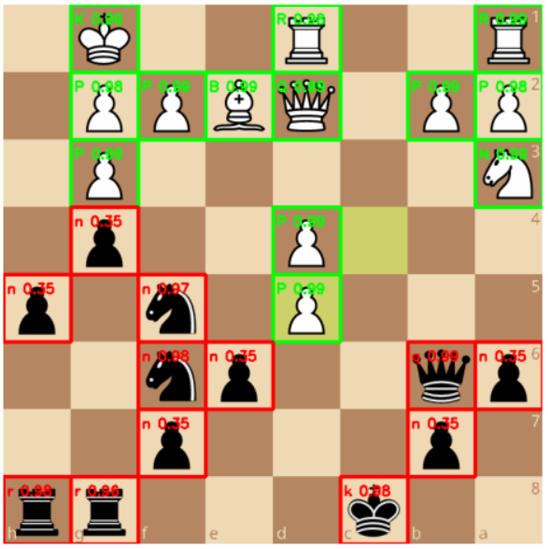

## **PROBLEMY Z MOTYWEM MERIDA**

### **1. Problem cienkich linii i antyaliasingu**
W przeciwieństwie do grubego i "kreskówkowego" stylu Cburnett, motyw Merida charakteryzuje się cieńszymi liniami i eleganckim cieniowaniem (antyaliasingiem) na krawędziach.
Standardowa maska binarna (progowanie kanału alfa przy wartości 127) "obcinała" półprzezroczyste krawędzie figur. Przez to szablony stawały się zbyt chude i poszarpane, co drastycznie obniżało wynik dopasowania (matchTemplate).

***Rozwiązanie: Obniżenie progu maski (z 127 na 10 lub 40), aby uwzględnić nawet delikatne, półprzezroczyste krawędzie figur.***

### **2. Problem kontrastu**
Czarne figury w motywie Merida są bardzo gęste i jednolite (mocno czarne).
Gdy czarna figura (np. Król lub Wieża) stała na ciemnym polu szachownicy, zlewała się z tłem w jedną ciemną plamę. Dla algorytmu kontrast między figurą a tłem był zbyt mały, przez co figury były niewidoczne (wynik poniżej progu).

***Rozwiązanie:***
- Przejście na skalę szarości (Grayscale) zamiast BGR, aby wyeliminować wpływ odcienia planszy.
- Zastosowanie CLAHE (Contrast Limited Adaptive Histogram Equalization) – algorytmu, który sztucznie "wyciąga" lokalny kontrast, sprawiając, że czarna figura odcina się od ciemnego tła.

### **3. Problem "Wysokiego Króla"**
Figury Merida są smukłe i wysokie. Król w tym motywie jest na tyle wysoki, że przy wycinaniu kwadratowego pola (np. 64x64 piksele) jego krzyżyk lub czubek głowy był ucinany. Szablon (zawierający całą figurę) nie pasował do uciętego fragmentu na zdjęciu.

***Rozwiązanie: Rozszerzenie zakresu skalowania w dół (dodanie skal 0.6 i 0.7), co pozwoliło dopasować mniejszy szablon do "tułowia" figury, ignorując uciętą górę.***

### **4. Problem z dominacją pionka**
To był najtrudniejszy problem. Kształt Piona jest prosty i "gładki". Kształt Konia czy Wieży w Meridzie jest skomplikowany (wiele szczegółów, wcięcia).
Algorytm mylił Czarne Konie i Wieże z Pionkami. Działo się tak, ponieważ prosty szablon Piona pasował "wystarczająco dobrze" do bryły Konia, podczas gdy skomplikowany szablon Konia miał niższy wynik przez detale, które nie pasowały idealnie (szum, piksele).

***Rozwiązanie:***
Wdrożenie Systemu Wag (Heurystyki):
- Kara dla Piona: Sztuczne obniżenie wyniku dopasowania dla pionków (np. x 0.70), ponieważ są one statystycznie najczęściej błędnie wykrywaną figurą ("false positive").
- Bonus dla Koni/Wież/Króla: Sztuczne podbicie wyniku dla trudnych figur (np. x 1.15 dla Konia, x 1.25 dla Wieży), aby w przypadku niepewności algorytm preferował figurę bardziej znaczącą niż pionek.

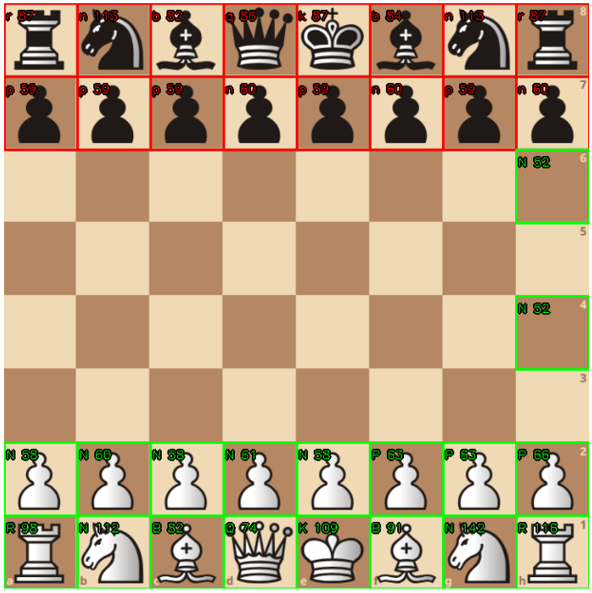

## **PROBLEMY Z MOTYWEM FRESCA**

### **1. Rozróżnianie kolorów**
To był główny powód, dla którego kod mylił białe pionki z czarnymi.W motywie Fresca biały i czarny pionek mają identyczny kształt (obrys). Metoda matchTemplate (zwłaszcza z normalizacją) skupia się na krawędziach, ignorując wypełnienie. Dla algorytmu biały i czarny pionek wyglądały tak samo – jak "kształt pionka".

***Rozwiązanie: Dodaliśmy korektę jasności. Po wykryciu kształtu algorytm zagląda teraz w sam środek pola:***
- Jeśli środek jest jasny (> 160) → to na pewno Biała figura.
- Jeśli środek jest ciemny (< 90) → to na pewno Czarna figura.

### **2. Uspokojenie "Systemu Wag"**
Poprzednia wersja (dla Meridy) miała ustawiony ogromny bonus (+50%) dla koni, ponieważ w Meridzie konie były bardzo trudne do wykrycia. W Fresca konie są wyraźniejsze. Przy tak wielkim bonusie algorytm zaczął "widzieć" konie wszędzie – nawet w pionkach i na pustych polach.

***Rozwiązanie: Zbalansowaliśmy wagi.***

- Bonus dla konia zmniejszyliśmy z +50% na +12%.

- Karę dla piona zmniejszyliśmy z -30% na -10%. To wystarczyło, żeby odróżnić konia od piona, ale przestało generować fałszywe alarmy.

### **3. Filtracja szumu na szarej szachownicy**
Zmieniliśy kolor szachownicy na szary. Po zastosowaniu filtru kontrastu (CLAHE), szare, puste pola stały się "ziarniste" (zaszumione). Algorytm myślał, że ten szum to fragment figury.

***Rozwiązanie: Podnieśliśmy próg odchylenia standardowego (np.std) z 10.0 na 25.0. Dzięki temu algorytm ignoruje "lekki szum" pustego pola i uznaje je za puste, zamiast próbować dopasować tam figurę na siłę.***

Fresca jest prostsza w kształtach (co jest plusem), ale przez to trudniejsza w rozróżnianiu kolorów (co wymagało dodatkowego kodu sprawdzającego jasność).

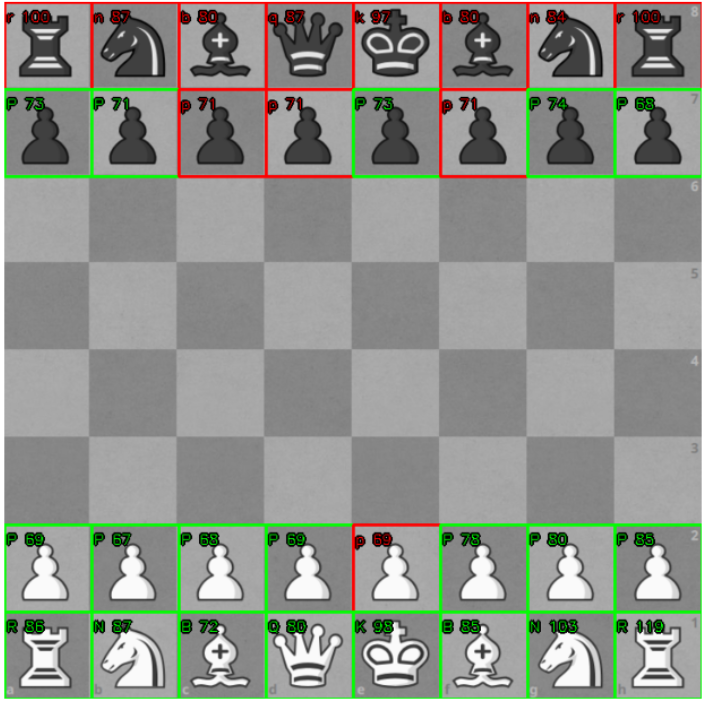

# **PODSUMOWANIE I WNIOSKI**

Celem zrealizowanego projektu było stworzenie systemu wizyjnego zdolnego do rozpoznawania sytuacji na szachownicy na podstawie zrzutów ekranu z platformy Lichess. Wykorzystując bibliotekę OpenCV oraz metodę dopasowywania wzorców (Template Matching), udało nam się opracować działający prototyp, który pomyślnie przeszedł testy na trzech wybranych motywach graficznych. Przeprowadzone eksperymenty potwierdziły, że w środowisku cyfrowym – gdzie grafiki figur są stałe i powtarzalne – metoda ta sprawdza się bardzo dobrze. Jest ona szybka obliczeniowo i nie wymaga trenowania skomplikowanych sieci neuronowych, co czyni ją idealnym rozwiązaniem do prostych zastosowań na statycznych obrazach.

W toku prac napotkaliśmy jednak wyzwania, które pozwoliły na sformułowanie istotnych wniosków. Największą trudnością okazała się różnorodność stylów graficznych bierek. Testy wykazały, że nie istnieje jeden uniwersalny próg detekcji (threshold) dla wszystkich motywów – figury o cienkich konturach wymagają zupełnie innych ustawień niż te masywne i wypełnione. Wymusiło to na nas indywidualną kalibrację algorytmu dla każdego zestawu, co wskazuje na konieczność precyzyjnego dostrajania parametrów w systemach opartych na wzorcach.

Projekt uwidocznił również fundamentalną różnicę między komputerowym "widzeniem" a "rozumieniem". Nasz program skutecznie lokalizuje figury na obrazie, jednak bez zaimplementowanej dodatkowej logiki gry (np. wykrywania orientacji planszy) nie potrafi w pełni poprawnie zinterpretować stanu rozgrywki, co objawia się problemami przy generowaniu kodu FEN dla gracza grającego czarnymi. Mimo tych ograniczeń, projekt uznajemy za udany – zrealizowaliśmy główny cel, jakim była automatyczna ekstrakcja informacji wizualnej z szachownicy, a zidentyfikowane problemy wyznaczają jasny kierunek dalszego rozwoju aplikacji.

## **JAK MOŻNA ROZWINĄĆ TEN PROJEKT?**

Obecna wersja programu stanowi solidną bazę (tzw. Proof of Concept), jednak aby stała się w pełni funkcjonalnym narzędziem dla szachistów, wymaga rozbudowy w kilku kluczowych obszarach. Priorytetem wydaje się być automatyczna detekcja orientacji planszy. W obecnej fazie brak rozpoznania, czy gracz steruje białymi czy czarnymi bierkami, prowadzi do błędów w generowaniu kodu FEN. Rozwiązaniem tego problemu mogłoby być zaimplementowanie prostego modułu OCR (Optyczne Rozpoznawanie Znaków), który odczytywałby współrzędne z ramki szachownicy (cyfry 1-8 lub litery A-H). Pozwoliłoby to programowi dynamicznie ustalać perspektywę i poprawnie mapować figury, niezależnie od obrotu planszy.

Kolejnym krokiem w stronę pełnej automatyzacji byłoby samodzielne rozpoznawanie stylu graficznego figur przez algorytm. Obecnie parametry detekcji muszą być dobierane ręcznie pod konkretny motyw. W przyszłości program mógłby przed właściwą analizą pobierać małą próbkę obrazu i analizować jej histogram lub cechy charakterystyczne. Porównując je z bazą wzorców, system automatycznie ładowałby odpowiedni zestaw grafik referencyjnych, co uczyniłoby narzędzie uniwersalnym bez ingerencji użytkownika.

Projekt posiada również duży potencjał w kontekście analizy czasu rzeczywistego. Ze względu na wysoką wydajność obliczeniową metody Template Matching, możliwe jest przejście z analizy statycznych zrzutów ekranu na przetwarzanie strumienia wideo (np. przechwytywanie pulpitu). Taka funkcjonalność pozwoliłaby na śledzenie partii na żywo i wyświetlanie dodatkowych informacji, takich jak ocena ruchu przez silnik szachowy, bezpośrednio obok planszy w trakcie rozgrywki.